In [161]:
#Import the required libraries
import pandas as pd
import os.path as osp

#Build the path for the data file
data_path = osp.join(
    osp.curdir,'banks.csv')

#Use the read_excel function to pull data from the 'Banks' sheet
data = pd.read_csv(data_path)


In [162]:
data.head()

,Obs,Financial Condition,TotCap/Assets,TotExp/Assets,TotLns&Lses/Assets
0,1,1,9.7,0.12,0.65
1,2,1,1.0,0.11,0.62
2,3,1,6.9,0.09,1.02
3,4,1,5.8,0.10,0.67
4,5,1,4.3,0.11,0.69


In [163]:
data.isna().sum()

Obs                    0
Financial Condition    0
TotCap/Assets          0
TotExp/Assets          0
TotLns&Lses/Assets     0
dtype: int64

In [164]:
from sklearn.model_selection import train_test_split
X = data[['TotExp/Assets','TotLns&Lses/Assets']]
Y = data['Financial Condition']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=0) 
#we set random state so we all get the same answers!

In [165]:
from sklearn.linear_model import LogisticRegression

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(X_train, y_train)

LogisticRegression(C=1e+42, solver='liblinear')

In [166]:
#Print the results and some evaluation criteria
from dmba.metric import AIC_score
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print('AIC', AIC_score(y_test, logit_reg.predict(X_test), df = len(X_train.columns)
+ 1))

intercept  -12.51950839882668
       TotExp/Assets  TotLns&Lses/Assets
coeff      84.005065              6.2125
AIC 14.276705583087743


In [167]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
X_train_1 = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_1).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Financial Condition   R-squared:                       0.500
Model:                             OLS   Adj. R-squared:                  0.409
Method:                  Least Squares   F-statistic:                     5.501
Date:                 Mon, 22 May 2023   Prob (F-statistic):             0.0221
Time:                         22:39:47   Log-Likelihood:                -5.1642
No. Observations:                   14   AIC:                             16.33
Df Residuals:                       11   BIC:                             18.25
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.4

c:\Users\Benoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [168]:
from dmba import classificationSummary

classificationSummary(y_train, logit_reg.predict(X_train))
classificationSummary(y_test, logit_reg.predict(X_test))

Confusion Matrix (Accuracy 0.9286)

       Prediction
Actual 0 1
     0 5 1
     1 0 8
Confusion Matrix (Accuracy 0.8333)

       Prediction
Actual 0 1
     0 3 1
     1 0 2


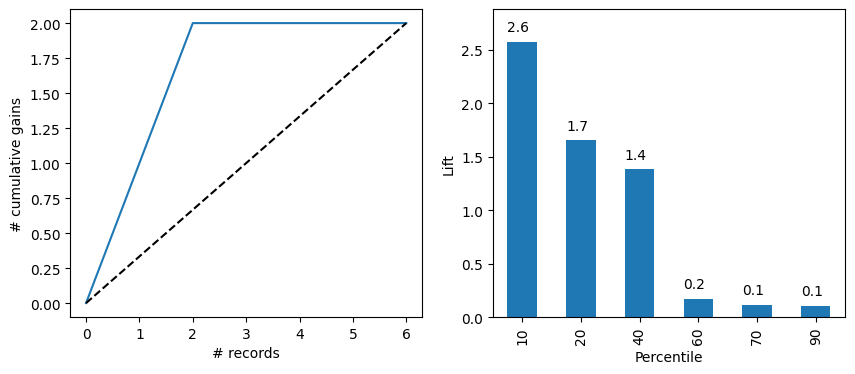

In [169]:
import matplotlib.pylab as plt
from dmba import gainsChart, liftChart

logit_reg_pred = logit_reg.predict(X_test)
logit_reg_proba = logit_reg.predict_proba(X_test)
logit_result = pd.DataFrame({'actual': y_test,
'p(0)': [p[0] for p in logit_reg_proba],
'p(1)': [p[1] for p in logit_reg_proba],
'predicted': logit_reg_pred })


df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

In [170]:
B0 = logit_reg.intercept_[0]
B1 = logit_reg.coef_[0][0]
B2 = logit_reg.coef_[0][1]

### 1. Write the estimated equation that associates the financial condition of a bank with its two predictors in three formats:

In [171]:
print('Logit = ',B0,'+',B1,' * TotExp/Assets +', B2,'* TotLns&Lses/Assets')
print('Odds = exp(',B0,'+',B1,' * TotExp/Assets +', B2,'* TotLns&Lses/Assets')
print('Probability = 1/1 +exp(-(',B0,'+',B1,' * TotExp/Assets +', B2,'* TotLns&Lses/Assets ))')

Logit =  -12.51950839882668 + 84.00506521757423  * TotExp/Assets + 6.212500121412245 * TotLns&Lses/Assets
Odds = exp( -12.51950839882668 + 84.00506521757423  * TotExp/Assets + 6.212500121412245 * TotLns&Lses/Assets
Probability = 1/1 +exp(-( -12.51950839882668 + 84.00506521757423  * TotExp/Assets + 6.212500121412245 * TotLns&Lses/Assets ))


### 2. Consider a new bank whose total loans and leases/assets ratio

In [172]:
Loans_and_leases_assets = 0.6
Expense_assets = 0.11

import numpy as np

In [173]:
Logit = B0 + B1 * Loans_and_leases_assets +B2 * Loans_and_leases_assets
print(f'Logit: {Logit:.4f}')

Logit: 41.6110


In [174]:
odds = np.exp(Logit)
print(f'Odds: {odds:.4f}')

Odds: 1178802544785552128.0000


In [175]:
probability = 1 / (1 + np.exp(-Logit))
print(f'Probability: {probability:.4f}')

Probability: 1.0000


### 3. The cutoff value of 0.5 is used in conjunction with the probability of being financially weak

In [176]:
cutoff = 0.5
odds_cutoff = cutoff/(1-cutoff)
print('The corresponding odd cutoff is', odds_cutoff)
print('The corresponding logit cutoff is', np.log(odds_cutoff))

The corresponding odd cutoff is 1.0
The corresponding logit cutoff is 0.0


In [ ]:
print('the coefficient for total loans & leases to total assets is',B2)
print('the coefficient for total loans & leases to total assetes in terms of odds is', np.log(B2))

### 5. When a bank that is in poor financial condition is misclassified as financially strong, the misclassification cost is much higher than when a financially strong bank is misclassified as weak. To minimize the expected cost of misclassification, should the cutoff value for classification (which is currently at 0.5) be increased or decreased?